# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Data

In [3]:
loan_data = pd.read_csv('Loan_Data.csv')
loan_data.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


# Exploratory Data Analysis

In [5]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


In [7]:
loan_data.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


In [9]:
loan_data.isnull().sum()

customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64

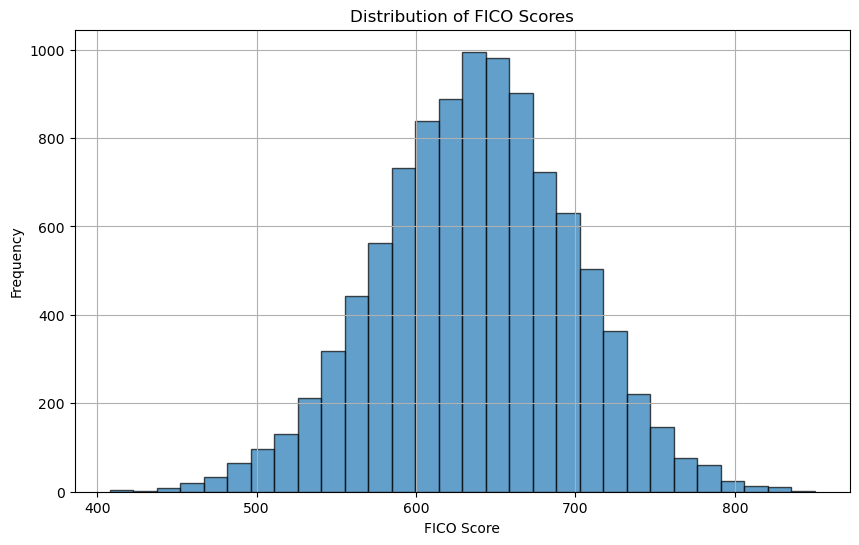

In [11]:
# Distribution of FICO scores
plt.figure(figsize=(10, 6))
plt.hist(loan_data['fico_score'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of FICO Scores')
plt.xlabel('FICO Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

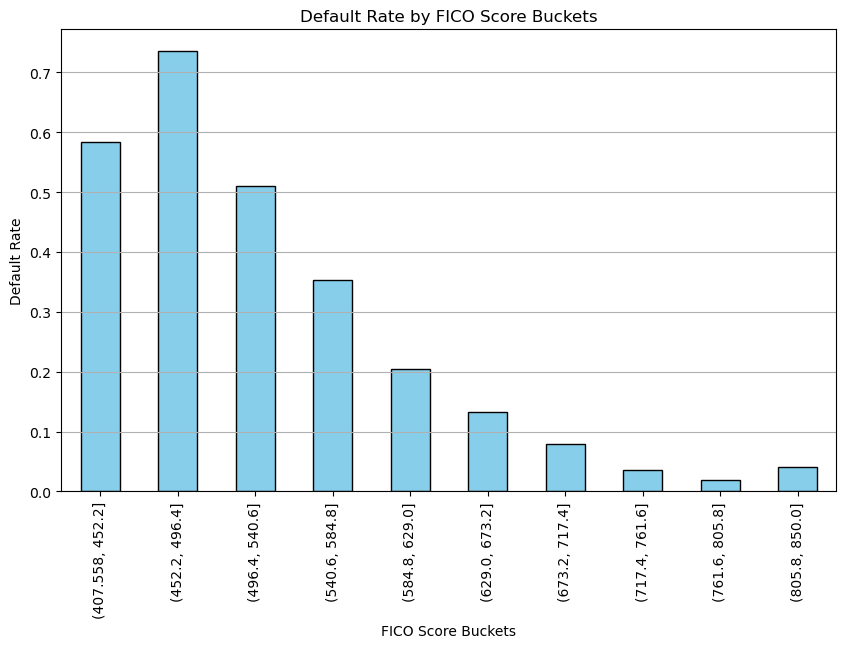

In [13]:
# Default rate vs FICO scores
loan_data['fico_bucket'] = pd.cut(loan_data['fico_score'], bins=10)

# Explicitly set observed=False to retain current behavior
default_rate = loan_data.groupby('fico_bucket', observed=False)['default'].mean()

plt.figure(figsize=(10, 6))
default_rate.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Default Rate by FICO Score Buckets')
plt.xlabel('FICO Score Buckets')
plt.ylabel('Default Rate')
plt.grid(axis='y')
plt.show()

# Preprocessing


In [15]:
# Keep only FICO scores within a valid range
loan_data = loan_data[(loan_data['fico_score'] >= 300) & (loan_data['fico_score'] <= 850)]

# Verification after cleaning
print(f"Remaining data after cleaning: {loan_data.shape[0]} rows")

Remaining data after cleaning: 10000 rows


# MSE

In [17]:
# Define the number of buckets
num_buckets = 5

# Reshape FICO scores for clustering
fico_scores = loan_data['fico_score'].values.reshape(-1, 1)

# Apply KMeans for quantization to minimize MSE
kmeans = KMeans(n_clusters=num_buckets, random_state=42, n_init=10)  # Explicitly set n_init
loan_data['fico_cluster'] = kmeans.fit_predict(fico_scores)

# Calculate bucket centers and assign ratings (lower is better)
cluster_centers = kmeans.cluster_centers_.flatten()
rating_map = {i: rank + 1 for rank, i in enumerate(np.argsort(cluster_centers))}
loan_data['fico_rating'] = loan_data['fico_cluster'].map(rating_map)

# Summary of the bucket mapping
bucket_summary = loan_data.groupby('fico_rating').agg(
    average_fico_score=('fico_score', 'mean'),
    default_rate=('default', 'mean'),
    count=('fico_score', 'size')
)

print(bucket_summary)

             average_fico_score  default_rate  count
fico_rating                                         
1                    522.066499      0.537014    797
2                    582.786697      0.282569   2180
3                    629.907583      0.166215   2954
4                    675.842494      0.094061   2711
5                    733.474963      0.044919   1358


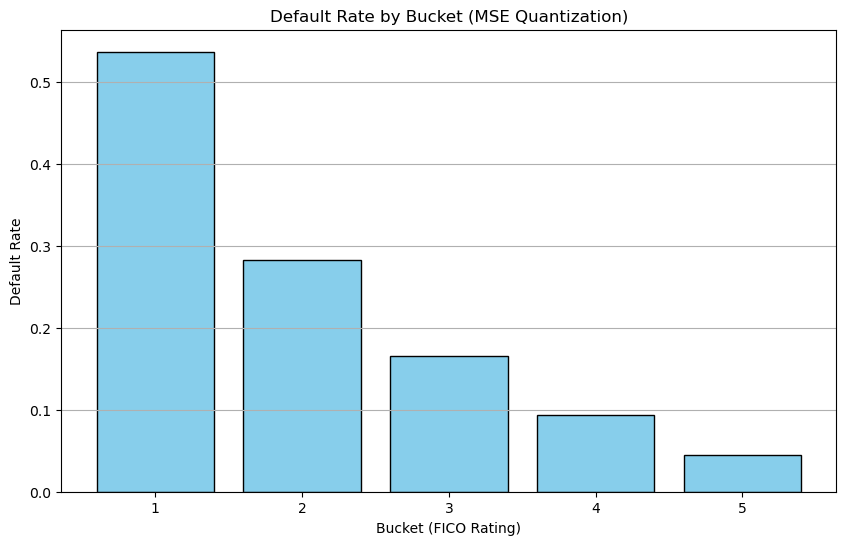

In [19]:
plt.figure(figsize=(10, 6))
plt.bar(bucket_summary.index, bucket_summary['default_rate'], color='skyblue', edgecolor='black')
plt.title("Default Rate by Bucket (MSE Quantization)")
plt.xlabel("Bucket (FICO Rating)")
plt.ylabel("Default Rate")
plt.grid(axis='y')
plt.show()

# Log-Likelihood

In [21]:
# Define bucket boundaries
bucket_edges = np.linspace(loan_data['fico_score'].min(), loan_data['fico_score'].max(), num_buckets + 1)
loan_data['log_bucket'] = pd.cut(loan_data['fico_score'], bins=bucket_edges, labels=False, include_lowest=True)

# Calculate metrics for each bucket
log_summary = loan_data.groupby('log_bucket').agg(
    total_defaults=('default', 'sum'),
    total_count=('fico_score', 'size'),
    average_fico_score=('fico_score', 'mean')
)

# Calculate log-likelihood for each bucket
def calculate_log_likelihood(k, n):
    if k == 0 or k == n:
        return 0
    p = k / n
    return k * np.log(p) + (n - k) * np.log(1 - p)

log_summary['log_likelihood'] = log_summary.apply(
    lambda row: calculate_log_likelihood(row['total_defaults'], row['total_count']), axis=1
)

print("\nSummary of buckets (Log-Likelihood):")
print(log_summary)


Summary of buckets (Log-Likelihood):
            total_defaults  total_count  average_fico_score  log_likelihood
log_bucket                                                                 
0                       93          129          476.286822      -76.377366
1                      692         1762          555.175936    -1180.462485
2                      890         5336          630.935345    -2405.267269
3                      172         2588          704.858578     -632.470528
4                        4          185          784.167568      -19.292688


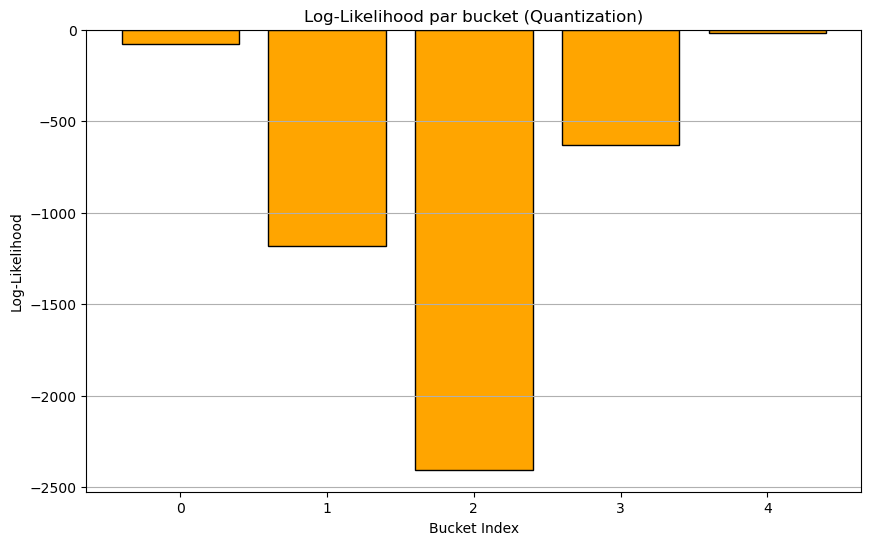

In [23]:
plt.figure(figsize=(10, 6))
plt.bar(log_summary.index, log_summary['log_likelihood'], color='orange', edgecolor='black')
plt.title("Log-Likelihood par bucket (Quantization)")
plt.xlabel("Bucket Index")
plt.ylabel("Log-Likelihood")
plt.grid(axis='y')
plt.show()

The analysis successfully quantized FICO scores into buckets, showing a clear relationship between lower FICO scores and higher default rates. Buckets with higher scores had fewer defaults and lower risk, validating the effectiveness of the quantization methods for assessing creditworthiness.